In [38]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

#=================================================
# Modify paths to point to output files
#=================================================
# Case name
case = 'Straight Coast'

# path to ocean_annual file
path_year = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/const_100yr/19000101.ocean_annual.nc'
dy = xr.open_dataset(path_year, decode_times=True)

# path to ocean_month file
path_month = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/const_100yr/19000101.ocean_month.nc'
dm = xr.open_dataset(path_month, decode_times=True)

# path to core file with zonal wind stress
path_core = '/data2/sragen/CORE/CORE_new/u_10.idealized.nc'
dc = xr.open_dataset(path_core, decode_times=True)

# path to save figures
fig_path = 'const_100yr/FIGURES/'

#=================================================
# Ignore runtime warnings: mean of empty slice
#=================================================
warnings.filterwarnings("ignore", message="Mean of empty slice")

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
x_west = np.where(dy['xh']==211)[0][0]
x_east = np.where(dy['xh']==351)[0][0]
y = np.where(dy['yq']==-35)[0][0]
y_south = np.where(dy['yq']==-71)[0][0]
y_north = np.where(dy['yq']==71)[0][0]

In [39]:
def calculate_basin_sfn(vmo, vhGM, x_west, x_east, y_south, y_north):
    vmo_slice = vmo.isel(time=slice(-31, -1)).mean(dim='time')
    vhGM_slice = vhGM.isel(time=slice(-31, -1)).mean(dim='time')
    sfn_basin_mean = (np.cumsum(np.nansum((vmo_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_res = (np.cumsum(np.nansum((vhGM_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_resmean = sfn_basin_mean + sfn_basin_res
    return sfn_basin_mean, sfn_basin_res, sfn_basin_resmean

sfn_small_mean, sfn_small_res, sfn_small_resmean = calculate_basin_sfn(dy['vmo'], dy['vhGM'], 
                                                                       x_west, x_east, y, y_north)
sfn_large_mean, sfn_large_res, sfn_large_resmean = calculate_basin_sfn(dy['vmo'], dy['vhGM'], 
                                                                       0, x_west, y, y_north)


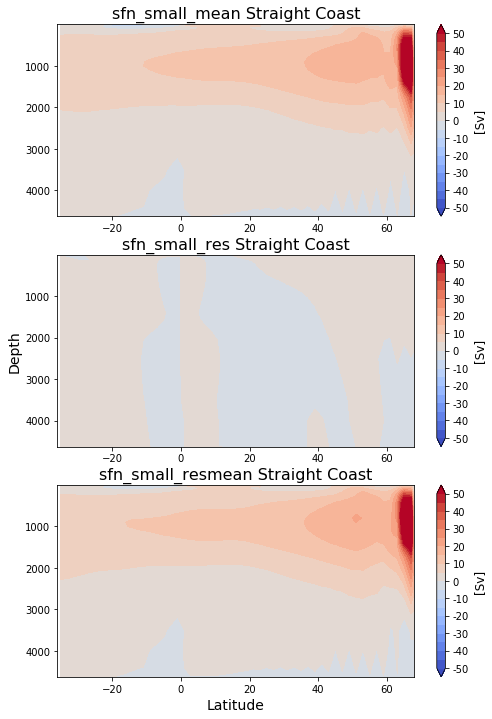

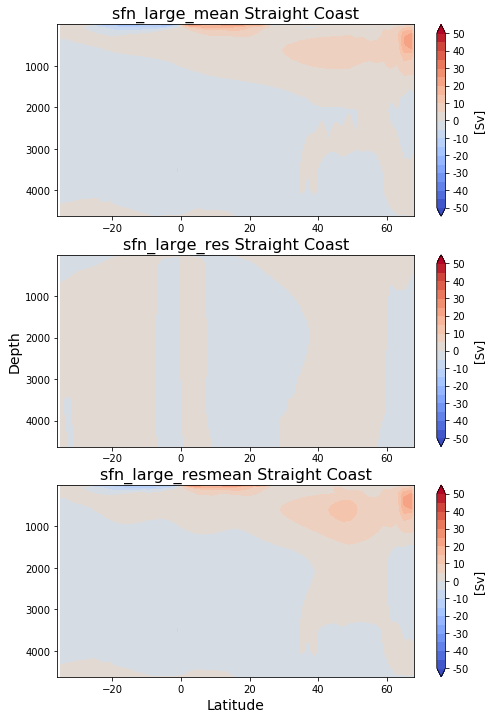

In [40]:
def variablename(*arg):
    names = []
    for i in range(len(arg)):
        item = [tpl[0] for tpl in filter(lambda x: arg[i] is x[1], globals().items())]
        names.append(item)
    str(names).strip('[]')
    return names

def plot_basin_sfn(sfn_mean, sfn_res, sfn_resmean, sfn_bound, y_south, y_north):
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    sfn_list = sfn_mean, sfn_res, sfn_resmean
    names = variablename(sfn_mean, sfn_res, sfn_resmean)
    for row in range(3):
        ax = axs[row]
        cf = ax.contourf(dy['yq'][y_south:y_north], dy['zl'], sfn_list[row][:,:], b, cmap='coolwarm', extend='both')
        ax.invert_yaxis()
        ax.set_xlim(dy['yh'][y_south], dy['yh'][y_north-1])
        ax.set_title('{}'.format(str(names[row]).strip("['']"))+' '+'{}'.format(case), fontsize=16)
        cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
        cbar.ax.set_ylabel('[Sv]', fontsize=12)
    axs[1].set_ylabel('Depth', fontsize=14), axs[2].set_xlabel('Latitude', fontsize=14)
    plt.show()
    return

plot_basin_sfn(sfn_small_mean, sfn_small_res, sfn_small_resmean, 50, y, y_north)
plot_basin_sfn(sfn_large_mean, sfn_large_res, sfn_large_resmean, 50, y, y_north)

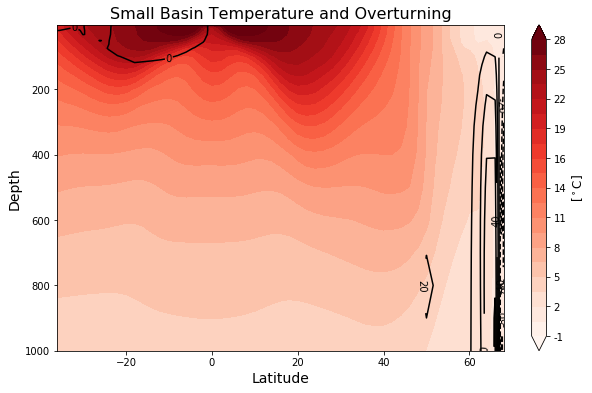

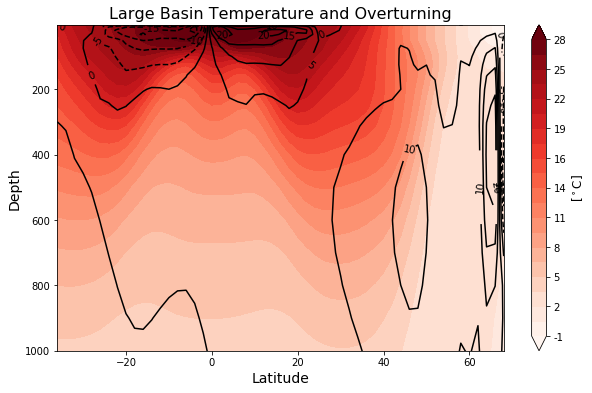

In [41]:
t = np.linspace(-1, 28, 11, endpoint=True)
b = np.linspace(-1, 28, 21, endpoint=True)
depth = 1000

fig, ax = plt.subplots(figsize=(10,6))
cf = ax.contourf(dy['yh'][y:y_north], dy['zl'], 
                 dy['thetao'].isel(yh=slice(y,y_north)).sel(xh=140, method='nearest').mean(dim='time'),
                b, cmap='Reds', extend='both') 
c = ax.contour(dy['yh'][y:y_north], dy['zl'], sfn_small_resmean, levels=10, colors='black')
ax.clabel(c, inline=True, inline_spacing=2, fmt='%.0f', fontsize=10, rightside_up=True)
ax.set_ylim(dy['zl'].sel(zl=0, method='nearest'), dy['zl'].sel(zl=depth, method='nearest'))
ax.invert_yaxis()
ax.set_title('Small Basin Temperature and Overturning', fontsize=16)
cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=12)
ax.set_ylabel('Depth', fontsize=14), ax.set_xlabel('Latitude', fontsize=14)
plt.savefig(fig_path+'small_temp_sfn.png')
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
cf = ax.contourf(dy['yh'][y:y_north], dy['zl'], 
                 dy['thetao'].isel(yh=slice(y,y_north)).sel(xh=50, method='nearest').mean(dim='time'),
                b, cmap='Reds', extend='both') 
c = ax.contour(dy['yh'][y:y_north], dy['zl'], sfn_large_resmean, levels=10, colors='black')
ax.clabel(c, inline=True, inline_spacing=2, fmt='%.0f', fontsize=10, rightside_up=True)
ax.set_ylim(dy['zl'].sel(zl=0, method='nearest'), dy['zl'].sel(zl=depth, method='nearest'))
ax.invert_yaxis()
ax.set_title('Large Basin Temperature and Overturning', fontsize=16)
cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=12)
ax.set_ylabel('Depth', fontsize=14), ax.set_xlabel('Latitude', fontsize=14)
plt.savefig(fig_path+'large_temp_sfn.png')
plt.show()

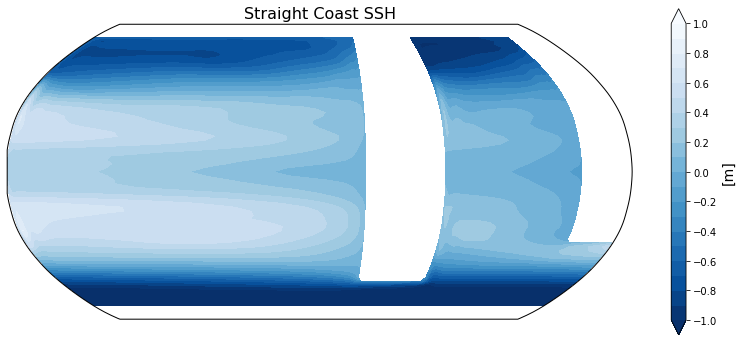

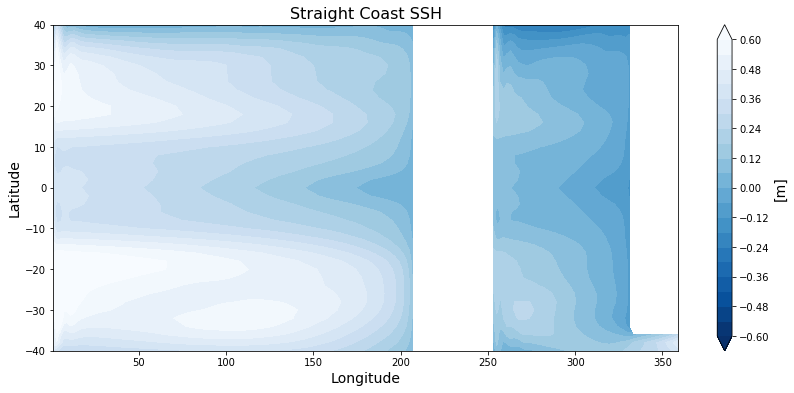

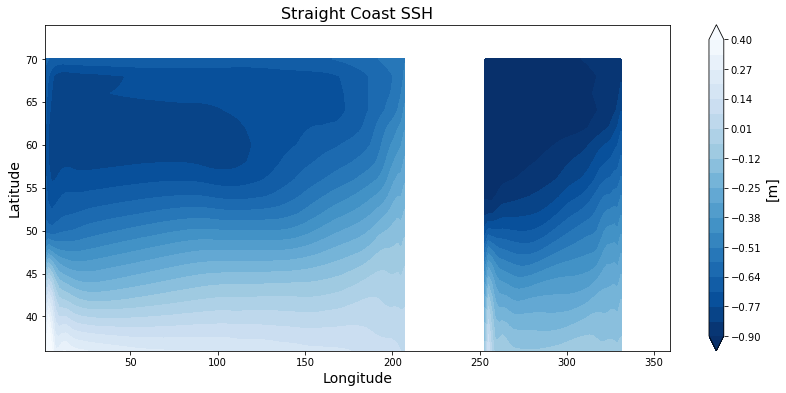

In [42]:
b_ssh = np.linspace(-1, 1, 21, endpoint=True)
t_ssh = np.linspace(-1, 1, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy['xh'], dy['yh'], dy['zos'].mean(dim='time'),
             b_ssh, cmap='Blues_r', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t_ssh, boundaries=t_ssh, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} SSH'.format(case), fontsize=16)
plt.savefig(fig_path+'SSH.png')
plt.show()


b_ssh = np.linspace(-0.6, 0.6, 21, endpoint=True)
t_ssh = np.linspace(-0.6, 0.6, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot()
plt.contourf(dy['xh'], dy['yh'].sel(yh=slice(-40,40)), dy['zos'].sel(yh=slice(-40,40)).mean(dim='time'),
             b_ssh, cmap='Blues_r', extend='both')
cbar = plt.colorbar(ticks=t_ssh, boundaries=t_ssh, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} SSH'.format(case), fontsize=16)
plt.savefig(fig_path+'SSH_tropics.png')
plt.show()


b_ssh = np.linspace(-0.9, 0.4, 21, endpoint=True)
t_ssh = np.linspace(-0.9, 0.4, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot()
plt.contourf(dy['xh'], dy['yh'].sel(yh=slice(35, 75)), dy['zos'].sel(yh=slice(35,75)).mean(dim='time'),
             b_ssh, cmap='Blues_r', extend='both')
cbar = plt.colorbar(ticks=t_ssh, boundaries=t_ssh, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} SSH'.format(case), fontsize=16)
plt.savefig(fig_path+'SSH_north.png')
plt.show()

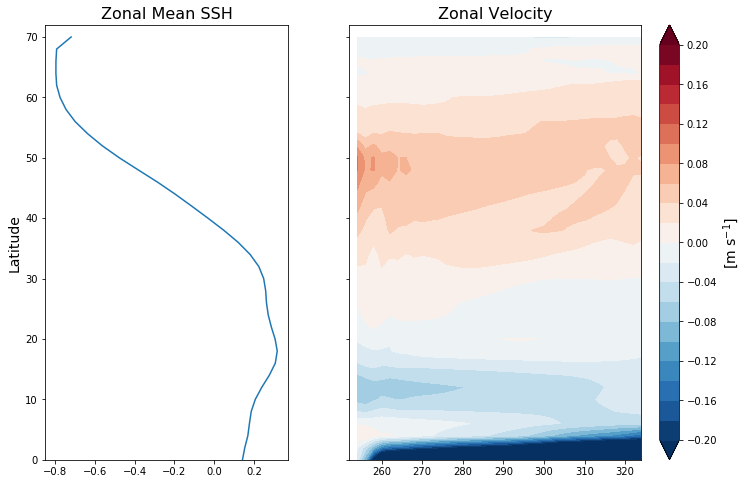

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,8), gridspec_kw={'width_ratios': [1, 1.5]})
axes[0].plot(dy['zos'].sel(yh=slice(0,72)).mean(dim='xh').mean(dim='time'), 
             dy['yh'].sel(yh=slice(0, 72)))
axes[0].set_ylim(0,72)
axes[0].set_title('Zonal Mean SSH', fontsize=16)
axes[0].set_ylabel('Latitude', fontsize=14)

b = np.linspace(-0.2, 0.2, 21, endpoint=True)
t = np.linspace(-0.2, 0.2, 11, endpoint=True)
c = axes[1].contourf(dm['xq'].sel(xq=slice(252,325)), dm['yh'].sel(yh=slice(0, 72)),
                 dm['uo'].sel(xq=slice(252,325)).sel(yh=slice(0, 72)).isel(zl=0).mean(dim='time'), 
                 b, cmap='RdBu_r', extend='both')
cbar = plt.colorbar(c, ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
axes[1].set_title('Zonal Velocity', fontsize=16)
plt.savefig(fig_path+'small_uo_ssh.png')
plt.show()

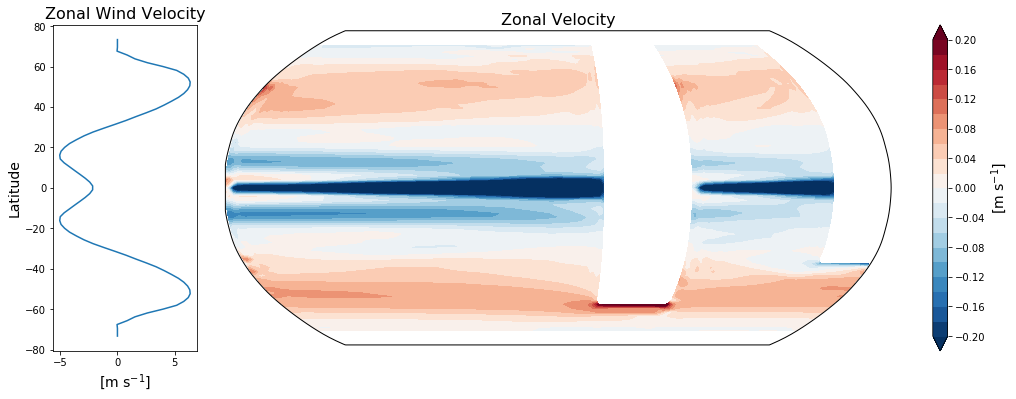

In [44]:
b = np.linspace(-0.2, 0.2, 21, endpoint=True)
t = np.linspace(-0.2, 0.2, 11, endpoint=True)

fig = plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1,6,1)
ax1.plot(dc['U_10'].sel(LAT=slice(-75,75)).mean(dim='LON').mean(dim='TIME'), dc['LAT'].sel(LAT=slice(-75,75)))
ax1.set_title('Zonal Wind Velocity', fontsize=16) 
ax1.set_ylabel('Latitude', fontsize=14); ax1.set_xlabel('[m s$^{-1}$]', fontsize=14)

ax2 = plt.subplot(1,6,(2,6), projection = ccrs.Robinson(central_longitude=180.0))
c = ax2.contourf(dy['xh'], dy['yh'], dm['uo'].isel(zl=0).mean(dim='time'), 
                 b, cmap='RdBu_r', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(c, ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Zonal Velocity', fontsize=16)
plt.savefig(fig_path+'Uo_winds.png')
plt.show()

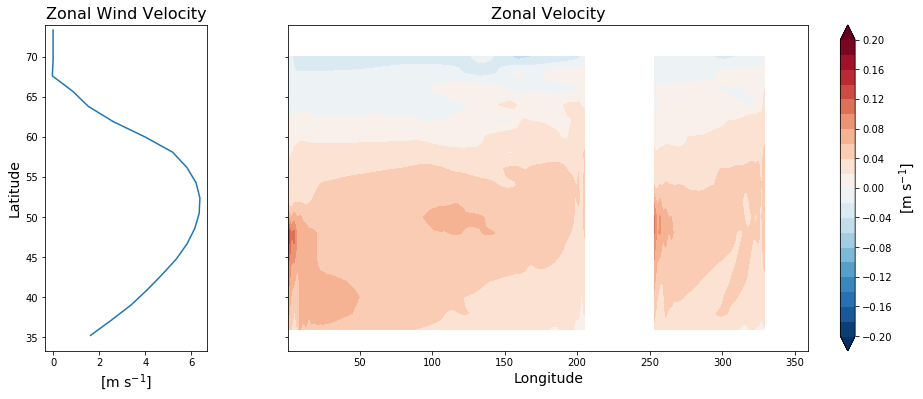

In [45]:
# fig = plt.figure(figsize=(14, 6))
# plt.contourf(dm['uo'].sel(yh=slice(35, 75)).isel(zl=0).mean(dim='time'), b, cmap='RdBu_r', extend='both')
# cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
# cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
# plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
# plt.title('Zonal Velocity', fontsize=16)
# plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,6), gridspec_kw={'width_ratios': [1, 4]})
ax1.plot(dc['U_10'].sel(LAT=slice(35,75)).mean(dim='LON').mean(dim='TIME'), dc['LAT'].sel(LAT=slice(35,75)))
ax1.set_title('Zonal Wind Velocity', fontsize=16) 
ax1.set_ylabel('Latitude', fontsize=14); ax1.set_xlabel('[m s$^{-1}$]', fontsize=14)

c = ax2.contourf(dy['xh'], dy['yh'].sel(yh=slice(35, 75)), 
                 dm['uo'].sel(yh=slice(35, 75)).isel(zl=0).mean(dim='time'), 
                 b, cmap='RdBu_r', extend='both')
cbar = plt.colorbar(c, ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.title('Zonal Velocity', fontsize=16)
plt.savefig(fig_path+'Uo_winds_north.png')
plt.show()

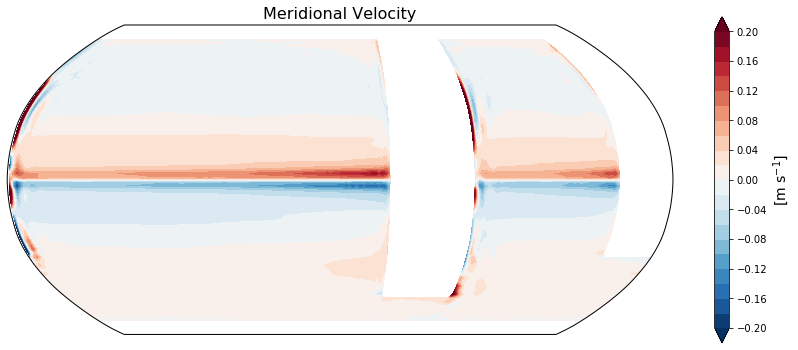

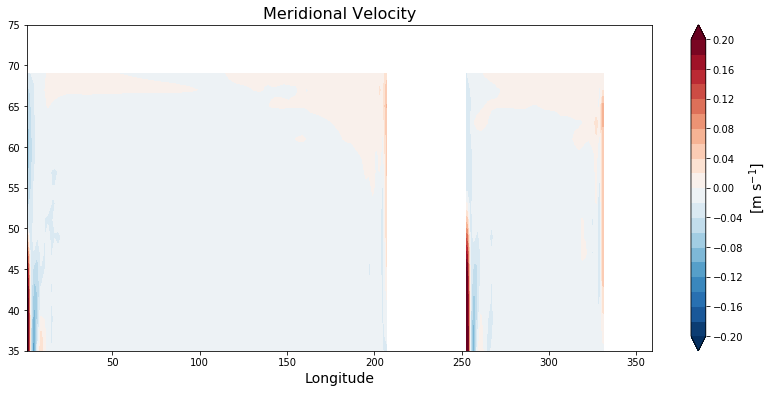

In [46]:
fig = plt.figure(figsize=(18, 6))
ax = plt.subplot(1,6,(2,6), projection = ccrs.Robinson(central_longitude=180.0))
c = ax.contourf(dm['xh'], dm['yq'], dm['vo'].isel(zl=0).mean(dim='time'), 
                 b, cmap='RdBu_r', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(c, ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Meridional Velocity', fontsize=16)
plt.savefig(fig_path+'Vo.png')
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
c = ax.contourf(dm['xh'], dm['yq'].sel(yq=slice(35, 75)), 
                 dm['vo'].sel(yq=slice(35, 75)).isel(zl=0).mean(dim='time'), 
                 b, cmap='RdBu_r', extend='both')
cbar = plt.colorbar(c, ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.title('Meridional Velocity', fontsize=16)
plt.savefig(fig_path+'Vo_north.png')
plt.show()